# Examining route attributes
Before, I had been only considering how these attributes can be compared across route alternatives, but instead of doing that, let's just look at the distance travelled on high stress facilities as this gives some evidence on people's willingness to travel on these facilities.

Look at distance rather than percent of route because a short trip with only a brief two block strech on a busy road is different than someone biking several miles on a stressful road that ends up being a smaller portion of the trip. Essentially, tolerance to stress from motor vehicles should in theory not vary with the distance of the trip. We're trying to find user profiles by acutally looking at the composition of links that they actually put themselves on.

However, it should be noted that distance will be limited in that there are only so many of a facility. Also, because sidewalks exist, this approach may run into issues in the case that someone is matched to a highstress road but they were actually on a sidewalk.

In [15]:
from pathlib import Path
import time
import geopandas as gpd
import numpy as np
import pickle
import networkx as nx
from shapely.ops import MultiLineString
import pandas as pd
import math
import matplotlib.pyplot as plt

from bikewaysim.paths import config
from bikewaysim.impedance_calibration import summarize_route, stochastic_optimization, post_calibration
from bikewaysim.routing import rustworkx_routing_funcs

In [2]:
# just make this a function

with (config['calibration_fp']/'ready_for_calibration.pkl').open('rb') as fh:
    ready_for_calibration = pickle.load(fh)
print(len(ready_for_calibration),'trips')

#new pickles
with (config['cycleatl_fp']/'trips_4.pkl').open('rb') as fh:
    trips = pickle.load(fh)
trips.reset_index(drop=True,inplace=True)
trips = trips[trips['tripid'].isin(ready_for_calibration.keys())]
with (config['cycleatl_fp']/'users_4.pkl').open('rb') as fh:
    users = pickle.load(fh)
users = users[users['userid'].isin(trips['userid'])]

#recalculate the number trips
users['matched_trips'] = users['userid'].map(trips.groupby('userid').size())

2577 trips


In [3]:
links, turns_df, length_dict, geo_dict, turn_G = rustworkx_routing_funcs.import_calibration_network(config)

In [4]:
# get the best performing full model so far
best_model = 'all,jaccard_buffer_mean,2'
with (config['calibration_fp']/f'loss/{best_model}.pkl').open('rb') as fh:
    best_model = pickle.load(fh)

# Dealing with cycletracks and multi-use path sidepaths.
Problem is that when two links are parallel and close together, the map matching algorithm may not route on the parallel bike infrastructure. Especially true when the infrastructure doesn't have good network connectivity. In this case, we want to acknowledge that there was a bicycle facility that they could have been on.

This happens in two instances:
1. Cycletracks
1. Mutli-Use Paths that are essentially wide sidewalks

Some trips may be matched to these features still so I think it's important that not only it be acknowledge that the road had an adjacent cycletrack/multi-use path but that the adjacent cycletrack/multi-use path also takes on the features of the adjacent road. That way, it won't matter how the trip was matched.

For an LTS style analysis, we want to know 

In [5]:
sidepaths = gpd.read_file(config['bicycle_facilities_fp']/'sidepaths.gpkg',layer='sidepaths',ignore_geometry=True)

First, add cycletrack / multi-use path attributes to streets

In [6]:
links = pd.merge(links,sidepaths,on='linkid',how='left')

In [7]:
# identify the roads with sidepath variables but no bicycle facility variables
cond = links['sidepath_linkid'].notna() & links['facility_fwd'].isna()

# assign sidepath to the road if it doesn't already have a facility
links.loc[cond,'facility_fwd'] = links.loc[cond,'sidepath']

# assign sidepath year if there is one
links.loc[cond & links['sidepath_year'].notna(),'year'] = links['sidepath_year']

Next, add street attributes to cycletracks / multi-use paths

In [8]:
# get the street attributes that we care about and then drop duplicates
# assign the highest value for each (NOTE: these sidepaths prolly need to be split up in OSM)
cols = ['AADT','speed','lanes']
to_add = links.loc[links['linkid'].isin(set(list(sidepaths['linkid']))),['sidepath_linkid']+cols].drop_duplicates()
# retrieve the highest value present
to_add = to_add.groupby('sidepath_linkid').max()
to_add['link_type'] = 'road'

In [9]:
links = links.merge(to_add,left_on='linkid',right_index=True,how='left',suffixes=(None,'_new'))
# replaces na values in the to_add column with the links data
for col in to_add.columns:
    links[col] = links[f'{col}_new'].fillna(links[col])
links.drop(columns=[x for x in links.columns if '_new' in x],inplace=True)

# Getting route attributes

In [10]:
#set index for quick retrieval
links.set_index(['linkid'],inplace=True)
turns_df.set_index(['source_linkid','source_reverse_link','target_linkid','target_reverse_link'],inplace=True)

links['length_mi'] = links['length_ft'] / 5280 
links['facility_fwd'] = links['facility_fwd'].fillna('No facility')

In [34]:
# item = ready_for_calibration[tripid]
# matched_edges = item['matched_edges']

def route_attributes(tripid,matched_edges):

    record = {}

    record['tripid'] = tripid

    # get links traversed
    trip_links = links.loc[matched_edges['linkid']] 
    route = [tuple(x) for x in matched_edges.values]

    # get the turn movements
    trip_turns = [(route[i][0],route[i][1],route[i+1][0],route[i+1][1]) for i in range(0,len(route)-1)]
    trip_turns = [x for x in trip_turns if x[0] != x[2]]
    trip_turns = turns_df.loc[trip_turns]

    #general stats
    record['length_mi'] = trip_links['length_mi'].sum().round(1)
    record['ascent_ft'] = trip_links['ascent_ft'].sum() # ascent seems a little high

    # turn stats
    record['left_turns'] = trip_turns['left_turn'].sum()
    record['right_turns'] = trip_turns['right_turn'].sum()
    record['unsig_crossing'] = trip_turns['unsig_crossing'].sum()  # these appear to match up to real world
    record['sig_crossings'] = trip_turns['signalized'].sum()

    #bike facilities
    bike_attrs = trip_links[trip_links['facility_fwd'].isin(['multi use path', 'bike lane', 'cycletrack', 'buffered bike lane'])]
    bike_attrs = bike_attrs.groupby('facility_fwd')['length_mi'].sum().to_dict()
    bike_attrs = {key+'_mi':item for key, item in bike_attrs.items()}
    record.update(bike_attrs)

    # road variables (no bike facilities)
    # remove if there's a bicycle facility
    road_attrs = trip_links[(trip_links['link_type']=='road') & (trip_links['facility_fwd'].isin(['multi use path', 'bike lane', 'cycletrack', 'buffered bike lane'])==False)].copy()
    
    aadt = {('aadt',str(key)+'_mi'):item for key, item in road_attrs.groupby('AADT')['length_mi'].sum().to_dict().items()}
    lanes = {('lanes',str(key)+'_mi'):item for key, item in road_attrs.groupby('lanes')['length_mi'].sum().to_dict().items()}
    speed = {('speed',str(key)+'_mi'):item for key, item in road_attrs.groupby('speed')['length_mi'].sum().to_dict().items()}

    record.update(aadt)
    record.update(lanes)
    record.update(speed)

    # road variables (w bike faciliies)
    road_attrs_w_bikeaccom = trip_links[(trip_links['link_type']=='road') & (trip_links['facility_fwd'].isin(['multi use path', 'bike lane', 'cycletrack', 'buffered bike lane']))].copy()

    aadt_bike = {('bike_aadt',str(key)+'_mi'):item for key, item in road_attrs_w_bikeaccom.groupby('AADT')['length_mi'].sum().to_dict().items()}
    lanes_bike = {('bike_lanes',str(key)+'_mi'):item for key, item in road_attrs_w_bikeaccom.groupby('lanes')['length_mi'].sum().to_dict().items()}
    speed_bike = {('bike_speed',str(key)+'_mi'):item for key, item in road_attrs_w_bikeaccom.groupby('speed')['length_mi'].sum().to_dict().items()}

    record.update(aadt_bike)
    record.update(lanes_bike)
    record.update(speed_bike)

    return record
chosen_route_attr = [route_attributes(key,item['matched_edges']) for key, item in ready_for_calibration.items()]
chosen_route_attr = pd.DataFrame.from_records(chosen_route_attr).fillna(0).round(2)
chosen_route_attr.set_index('tripid',inplace=True)
chosen_route_attr_norm = chosen_route_attr.drop(columns=['length_mi','ascent_ft']).div(chosen_route_attr['length_mi'],axis=0)

modeled_route_attr = [route_attributes(key,item['modeled_edges']) for key, item in best_model.items()]
modeled_route_attr = pd.DataFrame.from_records(modeled_route_attr).fillna(0).round(2)
modeled_route_attr.set_index('tripid',inplace=True)
modeled_route_attr_norm = modeled_route_attr.drop(columns=['length_mi','ascent_ft']).div(modeled_route_attr['length_mi'],axis=0)

shortest_route_attr = [route_attributes(key,item['shortest_edges']) for key, item in ready_for_calibration.items()]
shortest_route_attr = pd.DataFrame.from_records(shortest_route_attr).fillna(0).round(2)
shortest_route_attr.set_index('tripid',inplace=True)
shortest_route_attr_norm = shortest_route_attr.drop(columns=['length_mi','ascent_ft']).div(shortest_route_attr['length_mi'],axis=0)

In [35]:
# find difference
chosen_aligned, shortest_aligned = chosen_route_attr_norm.align(shortest_route_attr_norm, fill_value=0)
chosen_minus_shortest = chosen_aligned - shortest_aligned

chosen_aligned, modeled_aligned = chosen_route_attr_norm.align(modeled_route_attr_norm, fill_value=0)
chosen_minus_modeled = chosen_aligned - modeled_aligned

In [36]:
(chosen_minus_modeled ** 2).sum(axis=1).mean()

1.3577915205959739

In [65]:
max_val

2.0

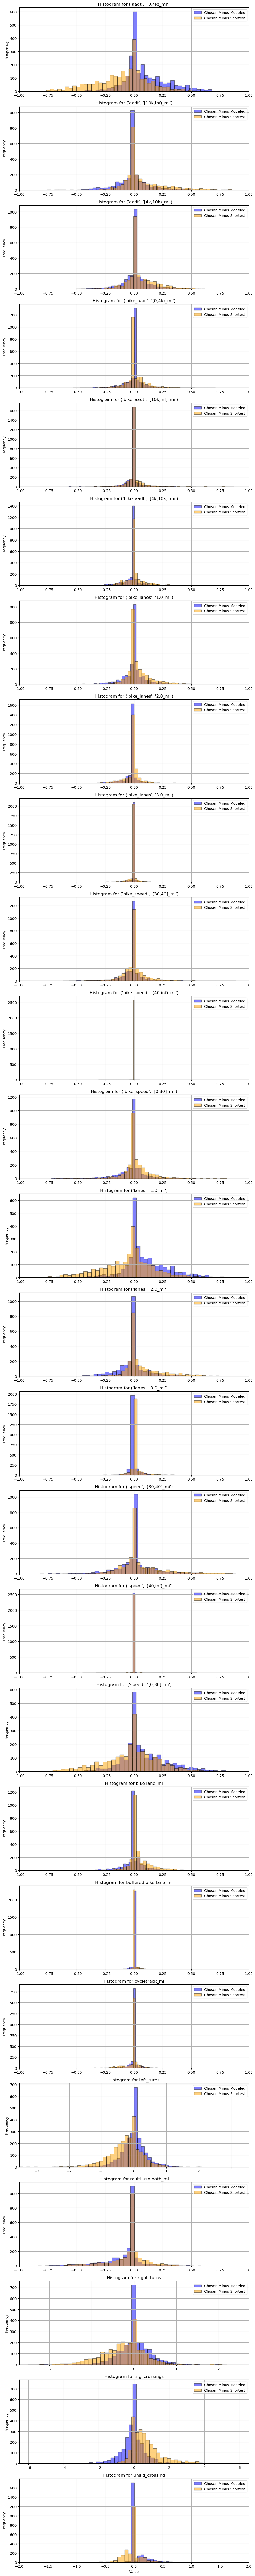

In [66]:
import matplotlib.pyplot as plt

# Define the number of columns to plot
columns = chosen_minus_modeled.columns  # Assuming both DataFrames have the same columns
num_columns = len(columns)

# Set up the figure and subplots
fig, axes = plt.subplots(num_columns, 1, figsize=(10, 100))

# Loop through each column and create a histogram
for i, column in enumerate(columns):
    # Plot histogram for chosen_minus_modeled
    axes[i].hist(chosen_minus_modeled[column].round(2), bins=50, alpha=0.5, color='blue', label='Chosen Minus Modeled', edgecolor='black')

    # Plot histogram for chosen_minus_shortest
    axes[i].hist(chosen_minus_shortest[column].round(2), bins=50, alpha=0.5, color='orange', label='Chosen Minus Shortest', edgecolor='black')

    # Set the title and labels for each subplot
    axes[i].set_title(f'Histogram for {column}')
    axes[i].set_ylabel('Frequency')
    
    # Center the histograms around zero by setting limits
    max_val = max(chosen_minus_modeled[column].max(), chosen_minus_shortest[column].max())
    min_val = min(chosen_minus_modeled[column].min(), chosen_minus_shortest[column].min())
    val = max(abs(max_val),abs(min_val))

    axes[i].set_xlim(min(val * -1, -1), max(val, 1))  # Adjust these limits based on your data

    # Add gridlines for better readability
    axes[i].grid(True)

    axes[i].legend()

# Set a common xlabel
axes[-1].set_xlabel('Value')

# Add a legend to the last subplot
# axes[-1].legend()

# Show the plot
plt.tight_layout()  # Adjust subplots to fit in the figure area.
plt.show()


In [21]:
(chosen_minus_shortest ** 2).sum(axis=1).mean()

0.0

In [22]:
dissaggregate = post_calibration.post_calibration_disaggregate()
cond = (dissaggregate.columns.get_level_values(0) == 'all') & \
    (dissaggregate.columns.get_level_values(1) == 'jaccard_buffer_mean') & \
    (dissaggregate.columns.get_level_values(2) == '2') & \
    (dissaggregate.columns.get_level_values(3) == 'jaccard_buffer')
dissaggregate = dissaggregate.loc[:,cond]
dissaggregate.columns = dissaggregate.columns.droplevel([0,1,2])

100%|██████████| 2564/2564 [00:15<00:00, 168.22it/s] 


In [108]:
# Align the two DataFrames by columns, filling missing columns with 0
chosen_aligned, modeled_aligned = chosen_pct.align(modeled_pct, fill_value=0)
chosen_minus_shortest = chosen_aligned - modeled_aligned


In [110]:
chosen_minus_shortest.round(2)

,"(aadt, [0,4k)_mi)","(aadt, [10k,inf)_mi)","(aadt, [4k,10k)_mi)","(bike_aadt, [0,4k)_mi)","(bike_aadt, [10k,inf)_mi)","(bike_aadt, [4k,10k)_mi)","(bike_lanes, 1.0_mi)","(bike_lanes, 2.0_mi)","(bike_lanes, 3.0_mi)","(bike_speed, (30,40]_mi)",...,bike lane_mi,buffered bike lane_mi,cycletrack_mi,left_turns,length_mi,multi use path_mi,right_turns,sig_crossings,tripid,unsig_crossing
0,0.40,-0.20,-0.10,0.07,0.00,-0.05,0.07,-0.05,0.00,0.00,...,0.05,0.00,-0.03,0,0.3,-0.05,3,-4,0,0
1,0.36,-0.07,-0.12,0.09,0.00,-0.13,0.02,-0.02,-0.05,0.00,...,-0.03,-0.00,0.00,1,0.5,-0.10,2,-2,0,0
2,0.01,-0.01,-0.00,-0.01,-0.02,-0.01,0.00,-0.02,-0.01,-0.02,...,-0.01,-0.01,-0.01,0,0.1,0.00,2,1,0,0
3,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0,0.0,0.00,0,0,0,0
4,0.33,-0.13,0.02,0.12,0.04,-0.07,0.08,-0.01,0.03,0.08,...,0.08,0.01,-0.09,2,-0.7,-0.21,2,-2,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2572,-0.05,0.04,-0.04,0.03,0.00,0.00,0.03,0.00,0.00,0.00,...,0.03,0.00,0.00,-1,0.0,0.03,-2,1,0,0
2573,-0.02,0.07,0.12,-0.19,0.00,-0.05,-0.34,0.17,-0.07,0.09,...,-0.38,-0.01,0.15,-3,0.6,0.01,-1,-1,0,0
2574,0.01,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0,0.0,-0.01,0,0,0,0
2575,0.18,0.00,-0.34,0.15,0.00,0.00,0.02,0.13,0.00,0.00,...,-0.04,0.00,0.22,1,0.0,-0.04,1,-1,0,0


In [97]:
modeled_pct.iloc[[0]] - chosen_pct.iloc[[0]]

,tripid,length_mi,ascent_ft,left_turns,right_turns,unsig_crossing,sig_crossings,bike lane_mi,multi use path_mi,"(aadt, [0,4k)_mi)",...,"(bike_lanes, 1.0_mi)","(bike_speed, [0,30]_mi)","(bike_speed, (30,40]_mi)","(bike_speed, (40,inf)_mi)",cycletrack_mi,buffered bike lane_mi,"(lanes, 2.0_mi)","(lanes, 3.0_mi)","(bike_lanes, 2.0_mi)","(bike_lanes, 3.0_mi)"
0,0,0.0,0.0,0,0,0,0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [98]:
modeled_pct.iloc[[0]]

,tripid,length_mi,ascent_ft,left_turns,right_turns,unsig_crossing,sig_crossings,bike lane_mi,multi use path_mi,"(aadt, [0,4k)_mi)",...,"(bike_lanes, 1.0_mi)","(bike_speed, [0,30]_mi)","(bike_speed, (30,40]_mi)","(bike_speed, (40,inf)_mi)",cycletrack_mi,buffered bike lane_mi,"(lanes, 2.0_mi)","(lanes, 3.0_mi)","(bike_lanes, 2.0_mi)","(bike_lanes, 3.0_mi)"
0,68,4.9,301.0,4,6,0,6,0.134694,0.193878,0.671429,...,0.134694,0.134694,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [99]:
chosen_pct.iloc[[0]]

,tripid,length_mi,ascent_ft,left_turns,right_turns,unsig_crossing,sig_crossings,bike lane_mi,multi use path_mi,"(aadt, [0,4k)_mi)",...,"(bike_lanes, 1.0_mi)","(bike_speed, [0,30]_mi)","(bike_speed, (30,40]_mi)","(bike_speed, (40,inf)_mi)",cycletrack_mi,buffered bike lane_mi,"(lanes, 2.0_mi)","(lanes, 3.0_mi)","(bike_lanes, 2.0_mi)","(bike_lanes, 3.0_mi)"
0,68,4.9,301.0,4,6,0,6,0.134694,0.193878,0.671429,...,0.134694,0.134694,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# normalize by distance


In [78]:
modeled.columns

Index([                  'tripid',                'length_mi',
                      'ascent_ft',               'left_turns',
                    'right_turns',           'unsig_crossing',
                  'sig_crossings',                'bike lane',
                 'multi use path',         ('aadt', '[0,4k)'),
             ('aadt', '[4k,10k)'),      ('aadt', '[10k,inf)'),
                   ('lanes', 1.0),        ('speed', '[0,30]'),
             ('speed', '(30,40]'),      ('speed', '(40,inf)'),
          ('bike_aadt', '[0,4k)'),  ('bike_aadt', '[4k,10k)'),
       ('bike_aadt', '[10k,inf)'),        ('bike_lanes', 1.0),
         ('bike_speed', '[0,30]'),  ('bike_speed', '(30,40]'),
       ('bike_speed', '(40,inf)'),               'cycletrack',
             'buffered bike lane',             ('lanes', 2.0),
                   ('lanes', 3.0),        ('bike_lanes', 2.0),
              ('bike_lanes', 3.0)],
      dtype='object')

In [79]:
df.columns

Index([                  'tripid',                'length_mi',
                      'ascent_ft',               'left_turns',
                    'right_turns',           'unsig_crossing',
                  'sig_crossings',                'bike lane',
                 'multi use path',         ('aadt', '[0,4k)'),
             ('aadt', '[4k,10k)'),      ('aadt', '[10k,inf)'),
                   ('lanes', 1.0),        ('speed', '[0,30]'),
             ('speed', '(30,40]'),      ('speed', '(40,inf)'),
          ('bike_aadt', '[0,4k)'),  ('bike_aadt', '[4k,10k)'),
       ('bike_aadt', '[10k,inf)'),        ('bike_lanes', 1.0),
         ('bike_speed', '[0,30]'),  ('bike_speed', '(30,40]'),
       ('bike_speed', '(40,inf)'),               'cycletrack',
             'buffered bike lane',             ('lanes', 2.0),
                   ('lanes', 3.0),        ('bike_lanes', 2.0),
              ('bike_lanes', 3.0)],
      dtype='object')

In [63]:
df.columns[-4][0]

'bike_speed'

In [60]:
# Check which column names are tuples
new_columns = [pd.MultiIndex.from_tuples([col]) if isinstance(col, tuple) else col for col in df.columns]

# Flatten the list of lists and set as new columns
# df.columns = pd.MultiIndex.from_tuples(sum(new_columns, []))

In [58]:
new_columns

[['tripid'],
 ['length_mi'],
 ['ascent_ft'],
 ['left_turn'],
 ['right_turn'],
 ['unsig_crossing'],
 ['signalized'],
 ['bike lane'],
 ['multi use path'],
 MultiIndex([('aadt', '[0,4k)')],
            ),
 MultiIndex([('aadt', '[4k,10k)')],
            ),
 MultiIndex([('aadt', '[10k,inf)')],
            ),
 MultiIndex([('lanes', 1.0)],
            ),
 MultiIndex([('speed', '[0,30]')],
            ),
 MultiIndex([('speed', '(30,40]')],
            ),
 MultiIndex([('speed', '(40,inf)')],
            ),
 MultiIndex([('bike_aadt', ('[0,4k)', 'bike lane'))],
            ),
 MultiIndex([('bike_aadt', ('[4k,10k)', 'bike lane'))],
            ),
 MultiIndex([('bike_aadt', ('[10k,inf)', 'bike lane'))],
            ),
 MultiIndex([('bike_lanes', (1.0, 'bike lane'))],
            ),
 MultiIndex([('bike_speed', ('[0,30]', 'bike lane'))],
            ),
 MultiIndex([('bike_speed', ('(30,40]', 'bike lane'))],
            ),
 MultiIndex([('bike_speed', ('(40,inf)', 'bike lane'))],
            ),
 ['cycl

In [22]:
trip_links['length_mi'].sum().round(1)

11.4

In [33]:
road_attrs.groupby('AADT')['length_mi'].sum().to_dict()

{'[0,4k)': 3.4944013293220824,
 '[4k,10k)': 3.2181722535775994,
 '[10k,inf)': 4.45404423331446}

In [32]:
pd.DataFrame.from_records([record])

,length_mi,ascent_ft,left_turns,right_turns,unsig_crossing,sig_crossings,bike lane,aadt,lanes,speed,aadt_bike
0,11.4,702.0,6,8,0,13,0.227828,"{'[0,4k)': 3.4944013293220824, '[4k,10k)': 3.2...","{1.0: 8.621414356169831, 2.0: 2.545203460044311}","{'[0,30]': 6.862161028912303, '(30,40]': 4.304...","{('[0,4k)', 'bike lane'): 0.22782778012052862,..."


In [31]:
record

{'length_mi': 11.4,
 'ascent_ft': 702.0,
 'left_turns': 6,
 'right_turns': 8,
 'unsig_crossing': 0,
 'sig_crossings': 13,
 'bike lane': 0.22782778012052862,
 'aadt': {'[0,4k)': 3.4944013293220824,
  '[4k,10k)': 3.2181722535775994,
  '[10k,inf)': 4.45404423331446},
 'lanes': {1.0: 8.621414356169831, 2.0: 2.545203460044311},
 'speed': {'[0,30]': 6.862161028912303,
  '(30,40]': 4.304456787301838,
  '(40,inf)': 0.0},
 'aadt_bike': {('[0,4k)', 'bike lane'): 0.22782778012052862,
  ('[4k,10k)', 'bike lane'): 0.0,
  ('[10k,inf)', 'bike lane'): 0.0}}

In [ ]:
turn_stats

In [ ]:
concat

In [ ]:
# need this to be column wise
trip_links[trip_links['link_type']=='road'].groupby(['AADT','lanes','speed','facility_fwd'])['length_mi'].sum()

In [ ]:
trip_links['length_mi'].sum()
trip_links['ascent_ft'].sum()

In [ ]:
links['facility_fwd'].unique()

Identify users with lots of mileage on "high-stress" facilities

In [ ]:
links.columns

In [ ]:
links['facility_fwd'].unique()

## Route attributes loop

In [45]:
from tqdm import tqdm
test = []
for tripid, item in tqdm(ready_for_calibration.items()):
    trip = item['matched_edges']

    # get links traversed
    trip_links = links.loc[trip['linkid']] 
    route = [tuple(x) for x in trip.values]

    # get the turn movements
    trip_turns = [(route[i][0],route[i][1],route[i+1][0],route[i+1][1]) for i in range(0,len(route)-1)]
    trip_turns = [x for x in trip_turns if x[0] != x[2]]
    trip_turns = turns_df.loc[trip_turns]

    #general stats
    general_stats = pd.Series({
        'length_mi': trip_links['length_mi'].sum().round(1),
        'ascent_ft': trip_links['ascent_ft'].sum(), # ascent seems a little high
    })
    general_stats.index.name = 'general stats'
    turn_stats = pd.Series({
        'left_turns': trip_turns['left_turn'].sum(),
        'right_turns': trip_turns['right_turn'].sum(),
        'unsig_crossing': trip_turns['unsig_crossing'].sum(),  # these appear to match up to real world
        'sig_crossings': trip_turns['signalized'].sum()
    })
    turn_stats.index.name = 'turn stats'

    #bike facilities
    bike_attrs = trip_links[trip_links['facility_fwd'].isin(['multi use path', 'bike lane', 'cycletrack', 'buffered bike lane'])]
    bike_attrs = bike_attrs.groupby('facility_fwd')['length_mi'].sum()

    # road variables (no bike facilities)
    # remove if there's a bicycle facility
    road_attrs = trip_links[(trip_links['link_type']=='road') & (trip_links['facility_fwd'].isin(['multi use path', 'bike lane', 'cycletrack', 'buffered bike lane'])==False)].copy()
    # route_attrs = trip_links[trip_links['link_type']=='road'].groupby(['AADT','lanes','speed'])['length_mi'].sum()
    aadt = road_attrs.groupby('AADT')['length_mi'].sum()
    lanes = road_attrs.groupby('lanes')['length_mi'].sum()
    speed = road_attrs.groupby('speed')['length_mi'].sum()

    #group these
    concat = [general_stats,bike_attrs,aadt,lanes,speed,turn_stats]
    concat = pd.concat(concat,keys=[x.index.name for x in concat])

    test.append(concat)

100%|██████████| 2577/2577 [02:02<00:00, 21.07it/s]


In [ ]:
test[2]

In [ ]:
pd.concat(test,axis=1)

In [ ]:
trip_links['length_mi'].sum()

In [ ]:
test[0]

In [ ]:
route_attrs_df = pd.concat(test,axis=1).transpose().fillna(0).round(2)

In [ ]:
x0 = pd.DataFrame(route_attrs_df.reset_index().values)
x0 = pd.merge(trips[['tripid','userid']],x0,left_on='tripid',right_on=0)
x0 = x0.drop(columns=['tripid',0]).groupby(['userid']).max()
x0.columns = route_attrs_df.columns

In [ ]:
x0

Get plots of the milage on various types of roads w/o bike facilities

In [ ]:
fig, ax = plt.subplots()
export_fp = r"C:\Users\tpassmore6\OneDrive - Georgia Institute of Technology\BikewaySim\Data\test"
for idx, x in enumerate(x0.columns):
    ax.hist(x0[x],color='grey',bins=[x/40 for x in range(0,225,5)]) # 0 to 3
    ax.set_xlim(0,6)
    ax.set_ylim(0,700)
    ax.title.set_text(str(x))
    plt.savefig(export_fp+rf"\{idx}.png")

In [ ]:
route_attrs_df.to_csv(Path.home()/'Downloads/route_attrs_df.csv')

In [ ]:
node_to_idx, idx_to_node = rustworkx_routing_funcs.rx_conversion_helpers(turn_G)

In [ ]:
a = (29485.0, False)
b = (29485.0, True)
a_idx = node_to_idx[a]
b_idx = node_to_idx[b]

In [ ]:
turn_G.edge_indices_from_endpoints(a_idx,b_idx)

In [ ]:
x = turns_df.reset_index()
x[x[['source_linkid','source_reverse_link']]==a]

In [ ]:
turns_df

In [ ]:
tripid

In [ ]:
trip_turns

In [ ]:
matched_summary = gpd.read_file(Path.home()/'Downloads/chosen_route_attributes.gpkg')
matched_summary.reset_index(drop=True,inplace=True)
# shortest_summary = gpd.read_file(Path.home()/'Downloads/shortest_route_attributes.gpkg')

In [ ]:
pct_cols = [x for x in matched_summary.columns if '_pct' in x]
for pct_col in pct_cols:
    matched_summary[pct_col.split('_pct')[0]] = matched_summary[pct_col] * matched_summary['length_mi'] / 100

In [ ]:
stress_cols = ['(30,40] mph','(40,inf) mph','2lpd','3+lpd','[10k,inf) aadt','[4k,10k) aadt']

In [ ]:
matched_summary = matched_summary.merge(trips[['tripid','userid']],on='tripid')

Now find the maximum distance travelled on a stressfull attribute by user

In [ ]:
matched_summary_user = matched_summary.groupby('userid')[stress_cols].max()

In [ ]:
matched_summary_user.columns

In [ ]:
n_cols = 2
n_rows = math.ceil(len(x_column) / n_cols)

matched_summary_user.hist(['(30,40] mph'],bins=100)

In [ ]:
matched_summary_user.hist('3+lpd',bins=100)

In [ ]:
matched_summary

How many miles are people riding on stressful streets? And can that be used to differentiate people?

In [ ]:
matched_summary['[10k,inf) aadt'].describe()

In [ ]:
matched_summary['(30,40] mph'].hist(bins=100)

In [ ]:
matched_summary.hist('[10k,inf) aadt',bins=100)

In [ ]:
matched_summary.hist('3+lpd_pct',bins=100)